<a href="https://colab.research.google.com/github/Azuremis/make_your_first_gan_with_pytorch/blob/master/mnist_classifier_refinements.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
# mount drive to read data files
from google.colab import drive
drive.mount("./mount")

Drive already mounted at ./mount; to attempt to forcibly remount, call drive.mount("./mount", force_remount=True).


In [51]:
# import libraries

import torch
import torch.nn as nn
from torch.utils.data import Dataset

import pandas 
import matplotlib.pyplot as plt

MNIST dataset class

In [52]:
class MnistDataset(Dataset):
  
    def __init__(self, csv_file):
        self.data_df = pandas.read_csv(csv_file, header=None)

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, index):
        # mage target (label)
        label = self.data_df.iloc[index, 0]
        target = torch.zeros((10))  # create target tensor 
        target[label] = 1.0  # using one hot encoding

        # image data (normalise from 0-255 to 0-1)
        image_values = torch.FloatTensor(self.data_df.iloc[index, 1:].values) / 255.0

        # return label, image data and target tensor
        return label, image_values, target

    def plot_image(self, index):
        # visualise image from pixels
        img_arr = self.data_df.iloc[index, 1:].values.reshape(28, 28) 
        plt.title("Label: " + str(self.data_df.iloc[index, 0]))
        plt.imshow(img_arr, interpolation='none', cmap="Blues")
        plt.show()




In [53]:
mnist_dataset = MnistDataset('mount/My Drive/Colab Notebooks/make_your_first_gan_with_pytorch/mnist_data/mnist_train.csv')

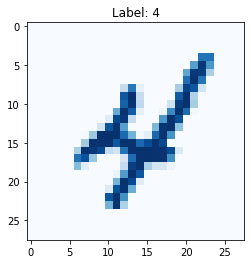

In [54]:
mnist_dataset.plot_image(9)

In [55]:
mnist_dataset[13]

(6,
 tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.1490, 0.8706, 0.8824, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.5765, 0.9176, 0.9882, 0.6902, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000,

Neural network class

In [71]:
# neural network class
class Classifier(nn.Module):

    def __init__(self):
        # initialise parent pytorch class
        super().__init__()

        # setup neural network architecture
        self.model = nn.Sequential(
            nn.Linear( 784, 200), #  fully connected mapping from 784 nodes to 200 nodes
            nn.LeakyReLU(0.02),  # apply LeakyReLU to ouput of 200 nodes
            nn.LayerNorm(200), # normalise network signals before final layer
            nn.Linear(200, 10),  # maps 200 nodes to 10 nodes
            nn.Sigmoid()  # apply sigmoid to output of 10 nodes to get final output
        )

        # setup loss function
        self.loss_function = nn.BCELoss()

        # setup optimiser using simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.01)

        # counter and accumulator to track progress
        self.counter = 0
        self.progress = []

    # setup forward method for passing information through network
    def forward(self, inputs):
        # run the model
        return self.model(inputs)

    def train(self, inputs, targets):
        # calculate nn outputs
        outputs = self.forward(inputs)

        # calculate loss
        loss = self.loss_function(outputs, targets)

        # update training progress trackers, accumulate loss val after 10 train ex
        self.counter += 1
        if (self.counter % 10 == 0):  
            self.progress.append(loss.item())  # loss.item() unwraps tensor
        
        # indicate speed of training to user
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)

        # process nn updates
        self.optimiser.zero_grad() # set gradients to zero
        loss.backward() # calculate gradients via backward pass
        self.optimiser.step() # update nn weights using gradients

    

    def plot_progress(self):
      df = pandas.DataFrame(self.progress, columns=["loss"])
      df.plot(ylim=(0, 1.0), figsize=(16, 8), alpha=0.1, marker=".",
              grid=True, yticks=(0, 0.25, 0.5))




Train neural network

In [72]:
# create neural network
nn_classifier = Classifier()

In [73]:
%%time

epochs = 3 # how mnay times to work through entire dataset 

for i in range(epochs):
  print("Training epoch: ", i+1, "of", epochs)
  # train nn on MNIST dataset
  for label, image_data_tensor, target_tensor in mnist_dataset:

    nn_classifier.train(image_data_tensor, target_tensor)
    



Training epoch:  1 of 3
counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
Training epoch:  2 of 3
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
Training epoch:  3 of 3
counter =  130000
counter =  140000
counter =  150000
counter =  160000
counter =  170000
counter =  180000
CPU times: user 12min 58s, sys: 12.1 s, total: 13min 10s
Wall time: 13min 18s


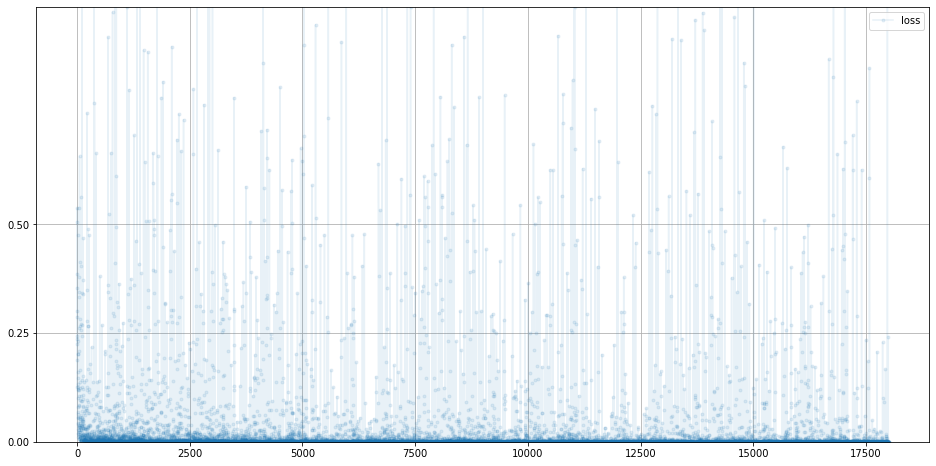

In [74]:
nn_classifier.plot_progress()

Querying trained network

In [75]:
# load mnist test data
mnist_test_data = MnistDataset('mount/My Drive/Colab Notebooks/make_your_first_gan_with_pytorch/mnist_data/mnist_test.csv')

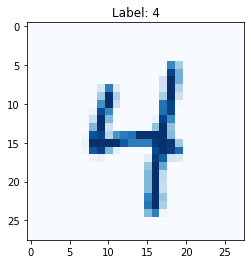

In [76]:
# pick a recrod
record = 19 # nth test example

# plot image with label
mnist_test_data.plot_image(record)

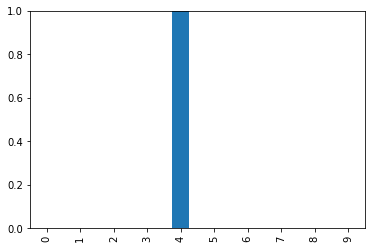

In [77]:
# extract image values for specified record
image_data = mnist_test_data[record][1]

# query trained network for prediction
output = nn_classifier.forward(image_data)

# plot output tensor 
pandas.DataFrame(output.detach().numpy()).plot(kind="bar", legend=False, ylim=(0, 1))

Classifier performance

In [78]:
# Check network performance on all test data

score, items = 0, 0

for label, image_data_tensor, target_tensor in mnist_test_data:
    answer = nn_classifier.forward(image_data_tensor).detach().numpy()

    if (answer.argmax() == label):
        score += 1
    items += 1

print(score, items, score / items)

9513 10000 0.9513
